In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, asShape 
import plotly.graph_objects as go
import plotly.express as px
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import polyline
import csv
import networkx as nx
import random
import matplotlib.ticker as mtick
import os


c:\Users\bst3191\anaconda3\envs\geospatial_environment\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
def make_geo_dataframe(df):
    """ Makes geodaframe from pandas dataframe"""
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Latitude, df.Longitude))
    gdf = gdf.set_crs('epsg:4326', inplace = True)
    return gdf

In [3]:
def make_line(points):
#this function makes lines out of points in geodataframes
    return LineString([p for p in points])

In [4]:
def make_point(coord):
    "This function makes a point out of coordinates for geopandas"
    return Point(coord)

In [5]:
def get_delimiter(file_path: str) -> str:
    with open(file_path, 'r') as csvfile:
        delimiter = str(csv.Sniffer().sniff(csvfile.read()).delimiter)
        return delimiter

In [6]:
def read_df_from_csv(file_path):
    delimiter = get_delimiter(file_path)
    df = pd.read_csv(file_path, delimiter = delimiter)
    return df

In [7]:
def find_lat_lon_tuple_in_dataframe(df, search_column_name, search_id):
    "This function finds and returns a lon lat tuple from dataframe in retrun column of dataframe"
    select_indices = np.where(df[search_column_name] == search_id)[0][0]
    lon = float(df._get_value(select_indices,'Longitude',takeable = False))
    lat = float(df._get_value(select_indices,'Latitude',takeable = False))
    return_tuple = (lon,lat)
    
    return return_tuple

In [8]:
def load_PipelineModels(filePath):
    "this function loads models from the IDRIC network."
    return pd.read_excel(f"{filePath}PIPELINE_MODELS.xlsx")

def load_ComponentModels(filePath):
    "this function loads models from the IDRIC network."
    return pd.read_excel(f"{filePath}COMPONENT_MODELS.xlsx")

In [9]:
def transform_half_hours_per_year(x):
    half_hours_per_year = 365*48
    y=x*half_hours_per_year
    return y

In [10]:
def make_rgb_range_0_1(colors):
    "this function turns rgb values (255, 125, 0) into rbg values ranign from 0-1, like (1, 0.5, 0)"
    for i in range(len(colors)):
        colors[i]= list(colors[i])
        for ii in range(len(colors[i])):
            color =  colors[i][ii]
            color /= 255
            colors[i][ii] = color
        colors[i]= tuple(colors[i])
    return(colors)

In [11]:
def make_rgb_range_0_1_from_tuple(color_tuple):
    "this function turns rgb values (255, 125, 0) into rbg values ranign from 0-1, like (1, 0.5, 0) from single tuple"
    color_tuple= list(color_tuple)
    for ii in range(len(color_tuple)):
        color =  color_tuple[ii]
        color /= 255
        color_tuple[ii] = color
    color_tuple= tuple(color_tuple)
    return(color_tuple)

## CCS network from idric model

In [12]:
number = 1
#CaseNames=["GER", "GER_w_trunklines_only_1_strg","GER_no_CCS", "GER_no_biomass", "GER_no_clay"]

CaseNames = ['SP_PT_Cementos']

country = CaseNames[number-1]
#country= "Test_Case"
print (country)
print (number)

folder_name = "No_collaboration"
path = f'../../Casestudy_results/{folder_name}/{country}'

#path = f"C:/Users/TSR/My Python projects/IDRIC Model(GitHub)/Casestudies/{country}"
name_run = 'snapshot100'


SP_PT_Cementos
1


In [13]:
#import results sheet from geospatial model: 
df_cement = read_df_from_csv(f'{path}/for_plots/Cement_plants_input_EU_all.csv')

#import input files from IDRIC model
df_existing_pipes =  read_df_from_csv(f'{path}/input/existing_pipelines.csv')
df_grid_idric = read_df_from_csv(f'{path}/input/grid_cells.csv')
df_transport = read_df_from_csv(f'{path}/input/TRANSPORT_COEFF.csv')

#load component models
filePath = f"{path}/input/"
df_pipe_models = load_PipelineModels(filePath)
df_component_models = load_ComponentModels(filePath)

#import output files from IDRIC model
df_results_idric = read_df_from_csv(f'{path}/Technology/{name_run}/num_pipes.csv')
df_results_idric_emissions = read_df_from_csv(f'{path}/Technology/{name_run}/emission_rate.csv')
df_results_pipes_invest = read_df_from_csv(f'{path}/Technology/{name_run}/num_pipes_invest.csv')
df_results_idric_tech_invest = read_df_from_csv(f'{path}/Technology/{name_run}/num_process_invest.csv')
df_results_idric_nets_invest = read_df_from_csv(f'{path}/Technology/{name_run}/num_end_use.csv')
df_results_idric_strg_invest = read_df_from_csv(f'{path}/Technology/{name_run}/num_strg.csv')
df_results_idric_prod_rate = read_df_from_csv(f'{path}/Technology/{name_run}/prod_rate.csv')
df_results_idric_flow_rate = read_df_from_csv(f'{path}/Technology/{name_run}/flow_rate.csv')


#add IDs, to pipelines (which don't have any when imported):
df_results_idric.insert(loc=0, column='OID', value='')
for index, row in df_results_idric.iterrows():
    df_results_idric.loc[index,"OID"] = f"PIPEID{index}"

#update all capacities from t/half hour to t/year
df_results_idric_prod_rate ["rate"] *= 17520
df_results_idric_flow_rate["rate"]*= 17520
df_pipe_models["FLOW_RSRC_MAX"]*=17520
df_component_models["NAME_PLATE_CAP"] *=17520
df_results_idric_emissions["rate"] *=17520


Create directory for outputfiles:

In [14]:
resultPath_postprocessing = f"{path}/Technology/{name_run}/Results_postprocessing"

# Check if the directory exists
if not os.path.exists(resultPath_postprocessing):
    # If it doesn't exist, create it
    os.makedirs(resultPath_postprocessing)

Show imported Grid cells:

In [15]:
fig = px.scatter_geo(lon=df_grid_idric.Longitude, lat=df_grid_idric.Latitude, text=df_grid_idric.Grid_id)
fig.write_html(f"{resultPath_postprocessing}/grid_points_{country}_{name_run}.html")
fig.show()

Look up points from df_cement and df_storage:

In [16]:
df_results_idric.insert(loc=len(df_results_idric.columns), column='From Point', value='')
df_results_idric.insert(loc=len(df_results_idric.columns), column='To Point', value='')

In [17]:
if not df_existing_pipes.empty:
    df_existing_pipes.insert(loc=len(df_existing_pipes.columns), column='From Point', value='')
    df_existing_pipes.insert(loc=len(df_existing_pipes.columns), column='To Point', value='')

First find lon-lat for each points of pipeline:

In [18]:
for index, row in df_results_idric.iterrows():
        df_results_idric.at[index,"From Point"] =  find_lat_lon_tuple_in_dataframe(df_grid_idric, 'Grid_id', row['From grid'])
        df_results_idric.at[index,"To Point"] =    find_lat_lon_tuple_in_dataframe(df_grid_idric, 'Grid_id', row['To grid'])  
        
if not df_existing_pipes.empty:
        for index, row in df_existing_pipes.iterrows():
                df_existing_pipes.at[index,"From Point"] =  find_lat_lon_tuple_in_dataframe(df_grid_idric, 'Grid_id', row['grid_from'])
                df_existing_pipes.at[index,"To Point"] =    find_lat_lon_tuple_in_dataframe(df_grid_idric, 'Grid_id', row['grid_to'])  

Second make line out of points:

In [19]:
df_results_idric['geometry'] = df_results_idric[["From Point", "To Point"]].apply(lambda x: make_line(x), axis=1)
gdf_results_pipeline = gpd.GeoDataFrame(df_results_idric, geometry = 'geometry', crs='epsg:4326')

if not df_existing_pipes.empty:
    df_existing_pipes['geometry'] = df_existing_pipes[["From Point", "To Point"]].apply(lambda x: make_line(x), axis=1)
    gdf_existing_pipes = gpd.GeoDataFrame(df_existing_pipes, geometry = 'geometry', crs='epsg:4326')

In [20]:
#gdf_results_pipeline.to_csv('C:/Users/TSR/My Python projects/geospatial analysis model/Results/pipeline_test.csv',sep=';')

# Plot results

In [21]:
import shapely.geometry
lats = []
lons = []
names = []

for feature, name in zip(gdf_results_pipeline.geometry,gdf_results_pipeline.index):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        names = np.append(names, [name]*len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        names = np.append(names, None)
        
        
fig = px.line_mapbox(lat=lats, lon=lons, hover_name=names,
                     mapbox_style="carto-positron", zoom=1)

# set size
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    #paper_bgcolor="LightSteelBlue",
)
fig.write_html(f"{resultPath_postprocessing}/network_{country}_{name_run}.html")
fig.show()

# Save as Shapefile

In [22]:
#select what to save
save_network = False
save_existing_pipe = False
save_cement_locations = False
#country = "Germany"

In [23]:
if save_network :
# export pipeline as shapefile
    gdf_export_pipeline = gdf_results_pipeline[['Distribution type','geometry']].copy()
    gdf_export_pipeline = gpd.GeoDataFrame(gdf_export_pipeline , geometry='geometry' , crs=4326)
    gdf_export_pipeline.to_file(f"{resultPath_postprocessing}/Pipielines_{country}_{name_run}.shp", driver='ESRI Shapefile')

if save_existing_pipe:
    if not df_existing_pipes.empty:
# export pipeline as shapefile
        gdf_export_existing_pipes = gdf_existing_pipes[['type','From VID', 'To VID','geometry']].copy()
        gdf_export_existing_pipes = gpd.GeoDataFrame(gdf_export_existing_pipes , geometry='geometry' , crs=4326)
        gdf_export_existing_pipes.to_file(f'{resultPath_postprocessing}/Exisiting_Pipielines_{country}_{name_run}.shp', driver='ESRI Shapefile')

if save_cement_locations: 
# export Cement locations sites as shapefile
    df_cement = make_geo_dataframe(df_cement)
    gdf_export_cement = df_cement[['VID', 'geometry']].copy()
    gdf_export_cement = gpd.GeoDataFrame(gdf_export_cement , geometry='geometry' , crs=4326)
    gdf_export_cement.to_file(f'{resultPath_postprocessing}/Cement_locations_{country}_{name_run}.shp', driver='ESRI Shapefile')

---
## Calculate Network costs

In [24]:
def pipeline_length(gdf):
 #this function calculates the lengths of the calculated pipline network in IDRIC.
   #Change pipeline crs
    gdf.to_crs('EPSG:23028', inplace=True)
    #Calculate distance:
    gdf['dist_km'] = gdf.length/1000
    #Change pipiline crs back:
    gdf.to_crs('epsg:4326', inplace = True)
    return

In [25]:
def find_value_in_dataframe(df, search_column_name, search_name, result_column_name):
    "This function looks up a value in another coulmn"
    select_indices = np.where(df[search_column_name] == search_name)[0][0]
    try:
        result = df._get_value(select_indices,result_column_name,takeable = False)
        #result = df_filtered[result_column_name].item()
    except: 
        result = 0
    return result

In [26]:
def find_value_in_dataframe_w_two_cond(df, search_column_name1, search_column_name2, search_name1, search_name2, result_column_name):
    "This function looks up a value in another column"
    df_filtered = df.loc[(df[search_column_name1] == search_name1) & (df[search_column_name2] == search_name2)]
    try:
        result = float(df_filtered[result_column_name])
    except:
        try:
            result = str(df_filtered[result_column_name].item())
        except:
            try:
                result = int(df_filtered[result_column_name])
            except: 
                result = 0
    return result

In [27]:
def currency_EUR_to_GBP(data_EUR):
    exchange_rate = 1.13	#https://www.finanzen.net/  Jan24th2023
    data_GBP = data_EUR / exchange_rate
    return data_GBP

In [28]:
def currency_GBP_to_EUR(data_GBP):
    exchange_rate = 1.13	#https://www.finanzen.net/  Jan24th2023
    data_EUR = data_GBP * exchange_rate
    return data_EUR

In [29]:
def calculate_costs_pipelines( df_models, type, dist_km): 
   "This function calculates the pipeline_costs"
   inv_factor = find_value_in_dataframe(df_models,"D",type,"NETWORK_COEFF\nCAPEX")
   opex_factor = find_value_in_dataframe(df_models,"D",type,"FLOW_COEFF\nOPEX")
   
   #CAPEX in €
   CAPEX =  inv_factor*1000*dist_km
   CAPEX = currency_GBP_to_EUR(CAPEX)
   
   #OPEX in €/a
   OPEX_fixed = opex_factor*1000*dist_km
   OPEX_fixed  = currency_GBP_to_EUR(OPEX_fixed )
   
   return CAPEX ,OPEX_fixed

In [30]:
def calc_resource_flow (df_component_models,type,resource,capacity):
    "This function calculates the needs of a resource from component models"
    resource_factor = find_value_in_dataframe(df_component_models,"J", type, resource)
    x = float(resource_factor)*capacity
    return x

In [31]:
def calculate_costs_interventions(df_models, type, number_of_plants, capacity): 
   "This function calculates the costs using the idric inputs"
   plate_cap = find_value_in_dataframe(df_models,"J",type,"NAME_PLATE_CAP")
   inv_factor = find_value_in_dataframe(df_models,"J",type,"INV_COEFF\nCAPEX")
   opex_factor = find_value_in_dataframe(df_models,"J",type,"INV_COEFF\nOPEX")
   process_factor = find_value_in_dataframe(df_models,"J",type,"PROCESS_COEFF\nOPEX")
   
   #calculate capex
   if plate_cap >0:
      cap_factor = (float(capacity)/float(number_of_plants))/float(plate_cap)
   else:
      cap_factor = 1
   CAPEX = inv_factor*1000*cap_factor*number_of_plants
   CAPEX = currency_GBP_to_EUR(CAPEX)

   #calculate fixed opex
   OPEX_fixed = opex_factor*1000*cap_factor*number_of_plants
   OPEX_fixed = currency_GBP_to_EUR(OPEX_fixed)

   #clacluate variable opex----------------
   OPEX_var = process_factor*1000*float(capacity)
   OPEX_var = currency_GBP_to_EUR(OPEX_var)
   
   return CAPEX, OPEX_fixed, OPEX_var

In [32]:
def add_transport_to_opex(df_models,type, df_transport,OPEX_var, grid, capacity):
    #import transport costs
    try:
        transport_coeff_olivine =find_value_in_dataframe_w_two_cond(df_transport,"RESOURCE","Grid_id","OLIVINE",grid,"TRANSPORT_COEFF")
    except:
        transport_coeff_olivine =0
    try:
        transport_coeff_biomass =find_value_in_dataframe_w_two_cond(df_transport,"RESOURCE","Grid_id","BIOMASS",grid,"TRANSPORT_COEFF")
    except:
        transport_coeff_biomass=0
    try:
        transport_coeff_clay =find_value_in_dataframe_w_two_cond(df_transport,"RESOURCE","Grid_id","CLAY",grid,"TRANSPORT_COEFF")
    except:
        transport_coeff_clay=0

    #import mass balance
    factor_olivine = find_value_in_dataframe(df_models,"J",type,"RESOURCE_CONV_RATE\nOLIVINE") 
    factor_biomass = find_value_in_dataframe(df_models,"J",type,"RESOURCE_CONV_RATE\nBIOMASS")
    factor_clay = find_value_in_dataframe(df_models,"J",type,"RESOURCE_CONV_RATE\nCLAY")

    #calculate OPEX (€/a)
    cost_olivine = -1*float(factor_olivine)*float(transport_coeff_olivine)*1000*float(capacity)
    cost_biomass = -1*float(factor_biomass)*float(transport_coeff_biomass)*1000*float(capacity)
    cost_clay = -1*float(factor_clay)*float(transport_coeff_clay)*1000*float(capacity)

    #Add OPEX to exisitng values
    OPEX_var += currency_GBP_to_EUR(cost_olivine + cost_biomass + cost_clay)

    return OPEX_var

In [33]:
def add_energy_to_opex(df_models,type, OPEX_var, capacity):
    
    #UPDATE THIS / CHANGE THISSS !!!!!!!!!!!!!!!!!!!!!!!!

    price_ELECTRICITY =   62 #GBP/WWH => UPDATE THIS
    NAT_GAS_HIGH_P    = 40 #GBP/MWH => UPDATE THIS!!!

    #import energy balance:
    factor_electricity = find_value_in_dataframe(df_models,"J",type,"RESOURCE_CONV_RATE\nELECTRICITY") #MWh/t
    
    
    #calculate OPEX
    OPEX_var += currency_EUR_to_GBP(-factor_electricity*price_ELECTRICITY)*float(capacity)
    return OPEX_var

In [34]:
def annualise_CAPEX (capex):
    "This function translates capex into annual costs"
    interest = 0.0769
    Lifetime = 20
    factor_annualisation = interest/(1-(1+interest)**-Lifetime)
    annual_capex = factor_annualisation*capex
    return annual_capex

In [35]:
def levelised_cost_calculator (capex, opex_fixed, opex_var,capacity):
    lcop = (annualise_CAPEX(capex) + opex_fixed +  opex_var)/(float(capacity))
    return lcop

We update all pipeline costs:

In [36]:
df_existing_pipes

,grid_from,grid_to,type,TM,EXSTNG_PIPES


In [37]:
#first update existing pipes:
if not df_existing_pipes.empty:
    for index, row in gdf_existing_pipes.iterrows():
        #find distribution type in existuing pipes
        distribution_type = find_value_in_dataframe_w_two_cond(gdf_existing_pipes, "grid_from", "grid_to", gdf_existing_pipes.loc[index,"grid_from"],gdf_existing_pipes.loc[index,"grid_to"], "type")
        #find correct index in results and update distribution type
        try: 
            select_indices = np.where((gdf_results_pipeline["From grid"] == gdf_existing_pipes.loc[index,"grid_from"]) & (gdf_results_pipeline["To grid"] == gdf_existing_pipes.loc[index,"grid_to"]))[0][0]
            gdf_results_pipeline.loc[select_indices,"Distribution type"]= distribution_type
        except:
            print("Error - not existing pipes not found in gdf_results_pipeline")
# second update invested pipes:

for index, row in df_results_pipes_invest.iterrows():
        #find distribution type in existuing pipes
        distribution_type = find_value_in_dataframe_w_two_cond(df_results_pipes_invest, "From grid", "To grid", df_results_pipes_invest.loc[index,"From grid"],df_results_pipes_invest.loc[index,"To grid"], "Distribution type")
        #print (distribution_type)
        #find correct index in results and update distribution type
        try: 
            select_indices = np.where((gdf_results_pipeline["From grid"] == df_results_pipes_invest.loc[index,"From grid"]) & (gdf_results_pipeline["To grid"] == df_results_pipes_invest.loc[index,"To grid"]))[0][0]
            gdf_results_pipeline.loc[select_indices,"Distribution type"]= distribution_type
        except:
            print("Error - not existing pipes not found in gdf_results_pipeline")


Calculate length of each pipeline built:

In [38]:
pipeline_length(gdf_results_pipeline) 
gdf_results_pipeline['dist_km'] = gdf_results_pipeline['dist_km'].round(2); # round results to two decimal places

Iiterate through the network and add the costs:

In [39]:
gdf_results_pipeline

,OID,From grid,To grid,Distribution type,Major time,Scenario,No. of units,From Point,To Point,geometry,dist_km
0,PIPEID0,1,4,12INCH_CO2_ONSHORE,1,LL,1.0,"(-4.15978, 42.874825)","(-4.46587, 41.941676)","LINESTRING (-4.15978 42.87483, -4.46587 41.94168)",107.65
1,PIPEID1,2,6,6INCH_CO2_ONSHORE,1,LL,1.0,"(-3.474441, 40.244961)","(-8.663498253, 41.13424079)","LINESTRING (-3.47444 40.24496, -8.66350 41.13424)",452.62
2,PIPEID2,3,1,6INCH_CO2_ONSHORE,1,LL,1.0,"(-2.190187, 42.882983)","(-4.15978, 42.874825)","LINESTRING (-2.19019 42.88298, -4.15978 42.87483)",162.71
3,PIPEID3,4,6,12INCH_CO2_ONSHORE,1,LL,1.0,"(-4.46587, 41.941676)","(-8.663498253, 41.13424079)","LINESTRING (-4.46587 41.94168, -8.66350 41.13424)",363.64
4,PIPEID4,5,9,9INCH_CO2_ONSHORE,1,LL,1.0,"(-5.865094, 37.359736)","(-6.836272132, 37.13771839)","LINESTRING (-5.86509 37.35974, -6.83627 37.13772)",90.23
5,PIPEID5,6,19,16INCH_CO2_OFFSHORE,1,LL,1.0,"(-8.663498253, 41.13424079)","(-8.922661842, 41.09598137)","LINESTRING (-8.66350 41.13424, -8.92266 41.09598)",22.24
6,PIPEID6,9,42,9INCH_CO2_OFFSHORE,1,LL,1.0,"(-6.836272132, 37.13771839)","(-7.324579604, 36.7747261)","LINESTRING (-6.83627 37.13772, -7.32458 36.77473)",59.62


In [40]:
# add capacity for interventions:
for index, row in df_results_idric_tech_invest.iterrows():
    df_results_idric_tech_invest.at[index,"capacity"] =  find_value_in_dataframe_w_two_cond(df_results_idric_prod_rate,'process_tech','grid',row['process_tech'],row['grid'],'rate')

# add capacity for end use technologies:
for index, row in df_results_idric_nets_invest.iterrows():
    df_results_idric_nets_invest.at[index,"capacity"] =  find_value_in_dataframe_w_two_cond(df_results_idric_prod_rate,'process_tech','grid',row['end_use_tech'],row['grid'],'rate')

In [41]:
#Add costs for network to results dataframe:
gdf_results_pipeline[["CAPEX_pipeline", "OPEX_fixed_pipeline"]] = gdf_results_pipeline.apply(lambda x: calculate_costs_pipelines(df_pipe_models, x['Distribution type'], x['dist_km']), axis=1, result_type='expand')

#Add costs for interventions to results dataframe:
df_results_idric_tech_invest[["CAPEX_tech","OPEX_fixed_tech", "OPEX_var_tech"]] = df_results_idric_tech_invest.apply(lambda x: calculate_costs_interventions(df_component_models, x['process_tech'], x['number'], x['capacity']), axis=1, result_type='expand')
df_results_idric_tech_invest["OPEX_var_tech"] = df_results_idric_tech_invest.apply(lambda x: add_transport_to_opex(df_component_models,x['process_tech'], df_transport,x["OPEX_var_tech"], x["grid"], x["capacity"]), axis=1)
df_results_idric_tech_invest["LCOP_tech"]= df_results_idric_tech_invest.apply(lambda x: levelised_cost_calculator(x["CAPEX_tech"],x["OPEX_fixed_tech"],x["OPEX_var_tech"], x["capacity"]), axis= 1)

#Add costs for NETs:
if not df_results_idric_nets_invest.empty:
    df_results_idric_nets_invest[["CAPEX_tech","OPEX_fixed_tech", "OPEX_var_tech"]]= df_results_idric_nets_invest.apply(lambda x: calculate_costs_interventions(df_component_models, x['end_use_tech'], x['number'], x['capacity']), axis=1, result_type='expand')
    #df_results_idric_nets_invest["OPEX_var_tech"] = df_results_idric_nets_invest.apply(lambda x: add_energy_to_opex(df_component_models,x['end_use_tech'], x["OPEX_var_tech"], x["capacity"]), axis=1)
#Add costs for storage
df_results_idric_strg_invest[["CAPEX_tech","OPEX_fixed_tech", "OPEX_var_tech"]] = df_results_idric_strg_invest.apply(lambda x: calculate_costs_interventions(df_component_models, x['strg_tech'], x['number'], 1), axis=1, result_type='expand')

Add emission stored and emitted to the atmosphere:

In [42]:
## Add CO2 fed into storage network
df_results_idric_tech_invest["CO2_stored"] = df_results_idric_tech_invest.apply(lambda x:calc_resource_flow(df_component_models,x['process_tech'],"RESOURCE_CONV_RATE\nCLIQ_CO2_ONSHORE",x["capacity"]), axis=1 )

## Add CO2 emitted:
df_results_idric_emissions = df_results_idric_emissions[df_results_idric_emissions["Resource"] == "EMITTED_CO2"]
df_results_idric_emissions.drop(columns=["Resource","Minor time", "Major Time", "Scenario"], axis = 1, inplace= True)
df_results_idric_emissions.rename(columns={"rate":"CO2_emitted"}, inplace = True)
df_results_idric_tech_invest= pd.merge(left= df_results_idric_tech_invest, right= df_results_idric_emissions, how='left', left_on=['grid'], right_on = ['grid'])

Calcualte network costs, by first determining CO2 tranpsort distance along the network. First create network from pipeline data:

In [43]:
def create_network_from_pipeline_results (df_results_idric):
    "This function creates a networkx network from idric dataframe."

    #rename columns so that networkx functions work on this
    df_results_idric.rename(columns={'From Point':'source', 'To Point':'target'}, inplace=True)

    #create network:
    G = nx.from_pandas_edgelist(
    df_results_idric,
    edge_key="Distribution type",
    create_using=nx.MultiGraph(),
    )

    #rename colums back to old names:
    df_results_idric.rename(columns={'source':'From Point', 'target':'To Point'}, inplace=True)
    
    #plot network if needed.
    #nx.draw(G)

    return G

In [44]:
#------------------------------------------------ Calculate each CO2 tranpsort route along network:
#create network
G=create_network_from_pipeline_results(df_results_idric)

#create temporary dataframe
df_temp = {'OID':[], 'geometry':[]}
df_temp = pd.DataFrame(df_temp)
df_temp["PIP_IDs"] = ""
df_temp["PIP_IDs"].astype('object')

df_grid_filtered_cement = df_grid_idric[df_grid_idric['OID'].str.contains("CID")] # here we only filter out cement options
#df_grid_filtered_cement = df_grid_filtered_cement[df_grid_filtered_cement['Grid_id'] == 7] # here we only filter out cement options

for index, row in df_grid_filtered_cement.iterrows():
    route = 0
    lat = find_value_in_dataframe(df_grid_idric,'OID',row['OID'],'Latitude')
    lon = find_value_in_dataframe(df_grid_idric,'OID',row['OID'],'Longitude')
    start_point = (lon, lat)
    try:
        test_set = nx.algorithms.descendants(G,start_point) # shows all the nodes a node is connected to   
    except:    
        test_set = "not_connected"   
    
    #find out which storage site the point is connected to:
    if not test_set == "not_connected":
        
        for val in test_set:
            df_results = pd.DataFrame()
            df_filtered = df_grid_idric[df_grid_idric['OID'].str.contains("SID")]
            test = find_value_in_dataframe_w_two_cond (df_filtered,'Longitude','Latitude',val[0],val[1],'OID')
            if not test == 0:
                storage_OID = test
                print (storage_OID)
                # calculate the distance the CO2 will have to travel from this plant to the storage site
                lat = find_value_in_dataframe(df_grid_idric,'OID',storage_OID,'Latitude')
                lon = find_value_in_dataframe(df_grid_idric,'OID',storage_OID,'Longitude')
                try:
                    #calculate route along pipeline network
                    route = nx.shortest_path(G, source= start_point, target=(lon,lat), weight=None, method='dijkstra')
                except:
                    route = []
                    df_temp[index,"dist_km"] = 0
                    #save route for CO2 along pipelines
                
        # add results to df_temp dataframe:
        df_temp.at[index,"OID"]=row['OID']
        #make line of route if a route was found: 
        if not route == 0:
            df_temp.at[index,"geometry"] = make_line(route)

    #identify Pipe IDs connected to the used route: 
        pipe_ids = [] # start with new list every iteration
        
        if not route ==0 :
            for point in range(len(route)-1):
                start = route[point]
                end = route[point+1]
                pipe_id = find_value_in_dataframe_w_two_cond(gdf_results_pipeline,"From Point", "To Point",start,end,"OID")
                pipe_ids.append(pipe_id)
           
        df_temp.at[index,"PIP_IDs"] = pipe_ids

#make geodataframe from temporary dataframe:
gdf_temp = gpd.GeoDataFrame(df_temp, geometry = 'geometry', crs='epsg:4326')

#calcualte pipline length to storage for each plant
if not gdf_temp.empty:
    pipeline_length(gdf_temp)
            
#rename "geometry" to "route_CO2" 
gdf_temp.rename_geometry('route_CO2', inplace=True)

#Put pipeline results into dataframe with results from grid: 
df_grid_filtered_cement = pd.merge(left=df_grid_filtered_cement, right=gdf_temp, how='left', left_on=['OID'],right_on = ['OID']).drop([
"GRIDTYPE",
"GRIDTYPECODE",
"TOT_CO2_STORES",
"LANDFALL",
"ONSHORE_GRIDS",
"IMPORT_LOCATIONS",
"EMISSION_FACTOR",
"LOCATION_FACTOR",
"AVAILABILITY",
"HARBOUR"], axis = 1)

#Add results from tech investment:
df_grid_filtered_cement = pd.merge(left= df_grid_filtered_cement, right= df_results_idric_tech_invest, how='left', left_on=['Grid_id'], right_on = ['grid']).drop(["Grid_id"],axis=1)

#make geo

SID132
SID132
SID132
SID132
SID155


In [45]:
route

[(-5.865094, 37.359736),
 (-6.836272132, 37.13771839),
 (-7.324579604, 36.7747261)]

Mark all pipelines that are existing pipelines (this will change the allocation methodology for the costs later on)

In [46]:
#check if pipeline was an existing pipe
gdf_results_pipeline["EXISTING_PIPE"] = ""
for index, row in gdf_results_pipeline.iterrows():
    test =find_value_in_dataframe_w_two_cond(df_existing_pipes, "grid_from", "grid_to",gdf_results_pipeline.loc[index,"From grid"],gdf_results_pipeline.loc[index,"To grid"], "EXSTNG_PIPES")
    if test == 1:
        gdf_results_pipeline.loc[index,"EXISTING_PIPE"] = True
    else:
        gdf_results_pipeline.loc[index,"EXISTING_PIPE"] = False
#gdf_results_pipeline

Add flow rates to each pipeline

In [47]:
#drop unnessary columns 
df_results_idric_flow_rate.drop(columns=["Distribution type",	"Distribution mode",	"Minor time",	"Major Time",	"Scenario"], axis=0, inplace = True)

#add flow rate to pipeline results:
gdf_results_pipeline = pd.merge(gdf_results_pipeline, df_results_idric_flow_rate,  how='left', left_on=['From grid','To grid'], right_on = ['From grid','To grid'])

#add maximum rate for each pipe type
gdf_results_pipeline ["max_rate"] = gdf_results_pipeline.apply(lambda x:find_value_in_dataframe(df_pipe_models, "D", x['Distribution type'], "FLOW_RSRC_MAX"), axis=1, result_type='expand')


Calculate CO2 Avoided emissions.

In [48]:
df_grid_filtered_cement["CO2_generated"] = df_grid_filtered_cement.apply(lambda x: calc_resource_flow(df_component_models,'INCUMBENT_CEMENT',"RESOURCE_CONV_RATE\nGENERATED_CO2",x["capacity"]), axis =1)
df_grid_filtered_cement["CO2_avoided"] = df_grid_filtered_cement.apply(lambda x: x['CO2_generated']-calc_resource_flow(df_component_models,x['process_tech'],"RESOURCE_CONV_RATE\nEMITTED_CO2",x["capacity"]), axis =1)
df_grid_filtered_cement["Decarb_rate"] = df_grid_filtered_cement.apply(lambda x: x["CO2_avoided"]/x["CO2_generated"], axis =1)

Drop cells with "No Action":

In [49]:
df_grid_filtered_cement= df_grid_filtered_cement[df_grid_filtered_cement.process_tech != "NO_ACTION"]

---
# Calculate the total network costs to be split up between all plants.

To split up the costs we can use to modes a) split up the entire network over all emitters using distance to storage site and amount of CO2 stored  or  b) only sections of pipelines that are shared by multiple plants are shared.

Select splitting mode:

In [50]:
allocation_mode_individual = True # if this variable is true, mode b) is selected. 

In [51]:
#------------------------------------------------Network costs ---------------------------------------------------------###
#sum up pipeline costs:
capex_network = gdf_results_pipeline["CAPEX_pipeline"].sum()
opex_network = gdf_results_pipeline["OPEX_fixed_pipeline"].sum()

#sum up compressor costs:
df_filtered = df_results_idric_tech_invest[df_results_idric_tech_invest['process_tech'].str.contains("COMPRESSOR")]
capex_comp = df_filtered["CAPEX_tech"].sum()
opex_comp = df_filtered["OPEX_fixed_tech"].sum()+df_filtered["OPEX_var_tech"].sum()

#sum up injection well costs: 
capex_strg = df_results_idric_strg_invest["CAPEX_tech"].sum()
opex_strg = df_results_idric_strg_invest["OPEX_fixed_tech"].sum()+df_results_idric_strg_invest["OPEX_var_tech"].sum()

#sum up costs
capex_storage_total =capex_comp + capex_strg
opex_storage_total =opex_comp + opex_strg
capex_network_total= capex_network + capex_storage_total 
opex_network_total = opex_network + opex_storage_total

#---------------------------------------------Negative Emissions Tech--------------------------------------------------####
if not df_results_idric_nets_invest.empty:
    capex_nets_total = df_results_idric_nets_invest["CAPEX_tech"].sum()
    opex_nets_total = df_results_idric_nets_invest["OPEX_fixed_tech"].sum()+df_results_idric_nets_invest["OPEX_var_tech"].sum()
else:
    capex_nets_total = 0
    opex_nets_total = 0

#---------------------------------------------Show some results-------------------------------------------------------####
#Print results on screen: 
print (f"CAPEX transport and storage:{capex_network_total/1000000} M€")
print (f"Annual CAPEX Network:{annualise_CAPEX(capex_network_total)/1000000} M€")
print (f"CAPEX NETS: {capex_nets_total/1000000} M€")
print (f"CAPEX transport:{capex_network/1000000} M€")
print (f"CAPEX compression:{capex_comp/1000000} M€")
print (f"CAPEX storage:{capex_strg/1000000} M€")

CAPEX transport and storage:896.7432816492469 M€
Annual CAPEX Network:89.2384659825952 M€
CAPEX NETS: 1046.388572748868 M€
CAPEX transport:513.9479591401066 M€
CAPEX compression:9.89532250914036 M€
CAPEX storage:372.9 M€


First we add levelized costs to pipeline network

In [52]:
gdf_results_pipeline["LCOP_transport"] = ""
for index,rows in gdf_results_pipeline.iterrows():

    factor_capacity = 0.5 # design capacity of trunklinge
    LCOP = 0

    if gdf_results_pipeline.loc[index,"EXISTING_PIPE"] == False:
        LCOP = (annualise_CAPEX(gdf_results_pipeline.loc[index,"CAPEX_pipeline"]) + gdf_results_pipeline.loc[index,"OPEX_fixed_pipeline"])/gdf_results_pipeline.loc[index,"rate"]
    elif gdf_results_pipeline.loc[index,"EXISTING_PIPE"] == True:
        LCOP = (annualise_CAPEX(gdf_results_pipeline.loc[index,"CAPEX_pipeline"]) + gdf_results_pipeline.loc[index,"OPEX_fixed_pipeline"])/(gdf_results_pipeline.loc[index,"max_rate"]*factor_capacity)
    
    gdf_results_pipeline.loc[index, "LCOP_transport"] = LCOP

gdf_results_pipeline["usage_percentage"] = gdf_results_pipeline.apply(lambda x: x["rate"]/x["max_rate"], axis= 1)

#gdf_results_pipeline.head(2)

We add the levelized costs to the df_cement, if allocation mode is individual:

In [53]:
if allocation_mode_individual:
    df_grid_filtered_cement["LCOP_transport_strg"] = ""
    for index, row in df_grid_filtered_cement.iterrows():
        pipe_idxs = df_grid_filtered_cement.loc[index,"PIP_IDs"]
        CO2_stored = df_grid_filtered_cement.loc[index, "CO2_stored"]
        LCOP_transport = 0
        # Run through used pipes and add each levelized cost per tonne of CO2 transported:
        if isinstance(pipe_idxs, list):
            for i in pipe_idxs:
                LCOP_transport += find_value_in_dataframe( gdf_results_pipeline, "OID", i, "LCOP_transport")
        
        # Turn LCOP per tonne of CO2 transported into per tonne of cement:#
        LCOP_transport *= (df_grid_filtered_cement.loc[index, "CO2_stored"])
        LCOP_transport /= (df_grid_filtered_cement.loc[index, "capacity"])

        # Save results back into dataframe: 
        df_grid_filtered_cement.loc[index, "LCOP_transport_strg"] = LCOP_transport

We add allocate costs for network (if not individual) and for storage:

In [54]:
df_grid_filtered_cement['capacity']=df_grid_filtered_cement['capacity'].astype('float')

# allocate costs:
if not allocation_mode_individual:
    df_grid_filtered_cement["dist*CO2"]=df_grid_filtered_cement.apply(lambda x: x["dist_km"]*x["CO2_stored"], axis = 1)
    specific_levelised_cost_transport = (annualise_CAPEX(capex_network_total)+opex_network_total)/df_grid_filtered_cement["dist*CO2"].sum()# specific costs per tonne and km
    df_grid_filtered_cement.drop(columns=["dist*CO2"],inplace=True)
    df_grid_filtered_cement["LCOP_transport_strg"] = df_grid_filtered_cement.apply(lambda x: x['dist_km']*x['CO2_stored']*specific_levelised_cost_transport/(x["capacity"]), axis=1)
elif allocation_mode_individual:
    specific_levelised_cost_storage = (annualise_CAPEX(capex_storage_total)+opex_storage_total)/df_grid_filtered_cement["CO2_stored"].sum()# specific costs per tonne and km
    df_grid_filtered_cement["LCOP_transport_strg"] = df_grid_filtered_cement.apply(lambda x: x["LCOP_transport_strg"] + x['CO2_stored']*specific_levelised_cost_storage/(x["capacity"]), axis=1)

#if no transport is used, replace NAN with 0
df_grid_filtered_cement["LCOP_transport_strg"].fillna(0, inplace = True)
df_grid_filtered_cement["LCOP_total"]= df_grid_filtered_cement.apply(lambda x: x["LCOP_tech"]+x["LCOP_transport_strg"], axis = 1)

Split up NET costs over all relevant grid points/ plants

In [55]:
if not df_results_idric_nets_invest.empty:
    #df_results_idric_nets_invest["number*cap"]=df_results_idric_nets_invest.apply(lambda x: float(x["number"])*float(x["capacity"]), axis = 1)
    df_results_idric_nets_invest = df_results_idric_nets_invest.astype({'capacity':'float'})#make sure capacity is a float for using it later
    specific_levelised_cost_nets = (annualise_CAPEX(capex_nets_total)+opex_nets_total)/((df_results_idric_nets_invest['capacity'].sum()))# specific costs per tonne of CO2 captured
    df_grid_filtered_cement["LCOP_nets"] = df_grid_filtered_cement.apply(lambda x: (x['CO2_emitted'])*specific_levelised_cost_nets/(x["capacity"]), axis=1)
else: 
    df_grid_filtered_cement["LCOP_nets"] = 0

Caluculate Offset emissions according to allocated NETs costs.

In [56]:
if not df_results_idric_nets_invest.empty:
    # NETs are equally spread over all emissions produced by one grid point /plant:
    capacity_nets= df_results_idric_nets_invest["capacity"].astype(float).sum()
    #adjust capacity to stored CO2: 
    factor_adjustment_NET = -find_value_in_dataframe(df_component_models,"J","NET","RESOURCE_CONV_RATE\nEMITTED_CO2")
    capacity_nets*= factor_adjustment_NET
    total_co2_emitted = df_grid_filtered_cement["CO2_emitted"].astype(float).sum()
    df_grid_filtered_cement["CO2_offset"] = df_grid_filtered_cement.apply(lambda x: capacity_nets*(x["CO2_emitted"]/total_co2_emitted), axis =1)

Calculate_avoidance costs:

In [57]:
df_grid_filtered_cement["LCOP_CO2_avoided"] = df_grid_filtered_cement.apply(lambda x: x["LCOP_total"]*x["capacity"]/x["CO2_avoided"], axis= 1)
df_grid_filtered_cement["LCOP_total_w_nets"] = df_grid_filtered_cement.apply(lambda x: x["LCOP_total"]+ x["LCOP_nets"], axis= 1)
df_grid_filtered_cement["LCOP_CO2_avoided_w_NETs"] = df_grid_filtered_cement.apply(lambda x: x["LCOP_total_w_nets"]*x["capacity"]/x["CO2_avoided"], axis= 1)

##Calculate average LCOP
average_LCOP_cement = sum(df_grid_filtered_cement["LCOP_total_w_nets"]*df_grid_filtered_cement["capacity"])/sum(df_grid_filtered_cement["capacity"])

## Plot results as MACCs

In [58]:
df_grid_filtered_cement.sort_values("LCOP_total_w_nets", ascending=True, inplace=True)

cummulative_reduction=0
cummulative_reduction_w_nets = 0
if not df_results_idric_nets_invest.empty:
    for index, row in df_grid_filtered_cement.iterrows():
        cummulative_reduction += (row['CO2_avoided']/df_grid_filtered_cement["CO2_generated"].sum())
        cummulative_reduction_w_nets += ((row['CO2_avoided']+row['CO2_offset'])/df_grid_filtered_cement["CO2_generated"].sum())
        df_grid_filtered_cement.at[index, 'Cummulative_CO2_avoided'] = cummulative_reduction
        df_grid_filtered_cement.at[index, 'Cummulative_CO2_avoided_w_nets'] = cummulative_reduction_w_nets
else:
    for index, row in df_grid_filtered_cement.iterrows():
        cummulative_reduction += (row['CO2_avoided']/df_grid_filtered_cement["CO2_generated"].sum())
        df_grid_filtered_cement.at[index, 'Cummulative_CO2_avoided'] = cummulative_reduction
        df_grid_filtered_cement.at[index, 'Cummulative_CO2_avoided_w_nets'] = cummulative_reduction



# Normalize results (due to rounding errors results can show up as +-1 % in the plots)
df_grid_filtered_cement["Cummulative_CO2_avoided_w_nets"] = df_grid_filtered_cement.apply(lambda x: x["Cummulative_CO2_avoided_w_nets"]/ cummulative_reduction_w_nets, axis = 1)


In [59]:
cummulative_reduction_w_nets

0.9963348926732574

In [60]:
df_grid_filtered_cement.reset_index(inplace=True)

In [61]:
df_grid_filtered_cement

,index,OID,Longitude,Latitude,latitude,longitude,parent_name,route_CO2,PIP_IDs,dist_km,...,Decarb_rate,LCOP_transport_strg,LCOP_total,LCOP_nets,CO2_offset,LCOP_CO2_avoided,LCOP_total_w_nets,LCOP_CO2_avoided_w_NETs,Cummulative_CO2_avoided,Cummulative_CO2_avoided_w_nets
0,4,CID81,-5.865094,37.359736,37.359736,-5.865094,Cementos Portland Valderrivas SA,"LINESTRING (-5.86509 37.35974, -6.83627 37.137...","[PIPEID4, PIPEID6]",149.856155,...,0.725477,9.183283,38.617375,33.300553,435958.923196,62.257080,71.917928,115.942636,0.186035,0.256897
1,0,CID77,-4.159780,42.874825,42.874825,-4.159780,Cementos Portland Valderrivas SA,"LINESTRING (-4.15978 42.87483, -4.46587 41.941...","[PIPEID0, PIPEID3, PIPEID5]",493.530791,...,0.725477,11.771076,41.523177,32.597533,479791.548833,66.941675,74.120709,119.493855,0.395190,0.544055
2,3,CID80,-4.465870,41.941676,41.941676,-4.465870,Cementos Portland Valderrivas SA,"LINESTRING (-4.46587 41.94168, -8.66350 41.134...","[PIPEID3, PIPEID5]",385.881191,...,0.725477,9.856149,41.260960,33.036355,335361.065748,66.518942,74.297315,119.778570,0.539442,0.742822
3,2,CID79,-2.190187,42.882983,42.882983,-2.190187,Cementos Portland Valderrivas SA,"LINESTRING (-2.19019 42.88298, -4.15978 42.874...","[PIPEID2, PIPEID0, PIPEID3, PIPEID5]",656.240344,...,0.725477,16.707786,46.925600,32.842136,187387.890759,75.651203,79.767736,128.597721,0.620522,0.854364
4,1,CID78,-3.474441,40.244961,40.244961,-3.474441,Cementos Portland Valderrivas SA,"LINESTRING (-3.47444 40.24496, -8.66350 41.134...","[PIPEID1, PIPEID5]",474.859167,...,0.725477,16.143866,50.766306,33.890689,250314.135691,81.843006,84.656995,136.479950,0.725477,1.000000


Set font size: 

In [62]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

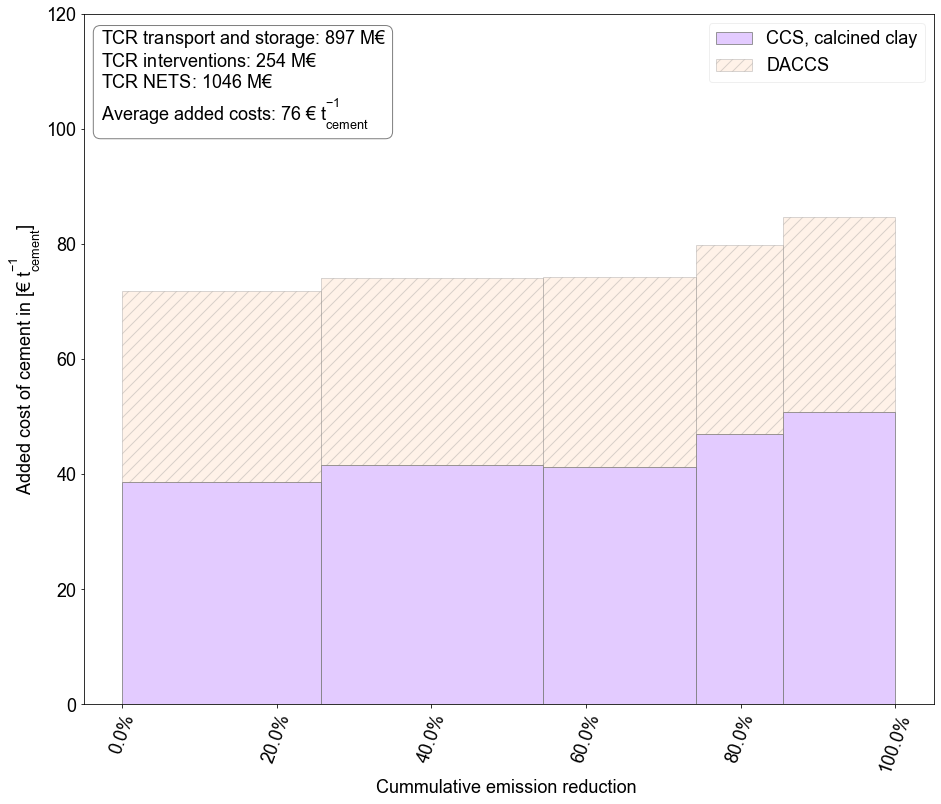

In [63]:
df_grid_filtered_cement.sort_values("LCOP_total_w_nets", ascending=True, inplace=True)

x = df_grid_filtered_cement['Cummulative_CO2_avoided_w_nets'].to_numpy()
y = df_grid_filtered_cement['LCOP_total'].to_numpy()

#calulate width for each bar:
for index, row in df_grid_filtered_cement.iterrows():
    if index == 0:
        df_grid_filtered_cement.at[index, 'Width_CO2_avoided_w_nets'] =df_grid_filtered_cement.at[index, 'Cummulative_CO2_avoided_w_nets']
    else:
        df_grid_filtered_cement.at[index, 'Width_CO2_avoided_w_nets'] =df_grid_filtered_cement.at[index, 'Cummulative_CO2_avoided_w_nets']- df_grid_filtered_cement.at[index-1, 'Cummulative_CO2_avoided_w_nets']



w = df_grid_filtered_cement['Width_CO2_avoided_w_nets'].to_numpy()


colors = {
"CCS_CEMENT":(128,0,0),
"BIOMASS_CEMENT":(128,128,0),
"CCS_BIOMASS_CEMENT":(60,180,75),
"MINERAL_CEMENT":(0,130,200), 
"BIOMASS_MINERAL_CEMENT":(0,128,128),
"CCS_BIOMASS_MINERAL_CEMENT":(170,110,40),
"CCS_MINERAL_CEMENT":(0,0,128),
"CALCINED_CLAY_CEMENT":(145,30,180),
"CALCINED_CLAY_BIOMASS_CEMENT":(240,50,230),
"CCS_CALCINED_CLAY_CEMENT":(220,190,255),
"CCS_CALCINED_CLAY_BIOMASS_CEMENT":(128,128,128),
"NETS":(255,215,180)}

labels = {
    "CCS_CEMENT":"CCS",
    "BIOMASS_CEMENT":"Biomass",
    "CCS_BIOMASS_CEMENT":"CCS, biomass",
    "MINERAL_CEMENT":"$CO_{2}$ mineralisation", 
    "BIOMASS_MINERAL_CEMENT":"$CO_{2}$ mineralisation, biomass",
    "CCS_BIOMASS_MINERAL_CEMENT":"CCS, $CO_{2}$ mineralisation, biomass",
    "CCS_MINERAL_CEMENT":"CCS, $CO_{2}$ mineralisation",
    "CALCINED_CLAY_CEMENT":"Calcined clay",
    "CALCINED_CLAY_BIOMASS_CEMENT":"Calcined clay, biomass",
    "CCS_CALCINED_CLAY_CEMENT":"CCS, calcined clay",
    "CCS_CALCINED_CLAY_BIOMASS_CEMENT":"CCS, calcined clay, biomass",
    "NETS":(255,216,177)

    }


# Plot the results through a loop:
xticks=[]
for n, c in enumerate(w):
    xticks.append((sum(w[:n]) + w[n]/2))
    
techs=df_grid_filtered_cement.process_tech.unique()

#create figure:
fig, ax = plt.subplots()
scale = 100

count= 0
color_idx = 0
legend=[]
for index, row in df_grid_filtered_cement.iterrows():
        df_grid_filtered_cement.loc[index,"xticks"]= row['Cummulative_CO2_avoided_w_nets']- row['Width_CO2_avoided_w_nets']/2

for l in techs:
    
    df_temp = df_grid_filtered_cement[df_grid_filtered_cement['process_tech'] == l] # here we only filter out cement options
    xticks = df_temp["xticks"].to_numpy()
    y = df_temp['LCOP_total'].to_numpy()
    y_2 = df_temp["LCOP_nets"].to_numpy()
    w = df_temp['Width_CO2_avoided_w_nets'].to_numpy()
    
    #Plot interventions
    #rgb = (random.random(), random.random(), random.random())
    colors_select = colors[l]
    colors_select = make_rgb_range_0_1_from_tuple(colors_select)
    rgb = colors_select

    a = plt.bar(xticks, height = y, width = w, color = rgb, edgecolor = 'grey', label=labels[l], alpha = 0.8)
    if count == 0:
        b =plt.bar(xticks, height = y_2, width = w,bottom =y , color = make_rgb_range_0_1_from_tuple(colors["NETS"]), edgecolor = 'grey', label="DACCS", alpha = 0.3, hatch="//")
    else:
        b =plt.bar(xticks, height = y_2, width = w,bottom =y , color = make_rgb_range_0_1_from_tuple(colors["NETS"]), edgecolor = 'grey', alpha = 0.3, hatch="//")
    plt.xticks(rotation=45)

    #add cout for xticks:
    count = xticks[len(xticks) - 1]+w[len(xticks) - 1]/2

    #advance index for color selection: 
    color_idx += 1

legend = plt.legend(loc='upper right')
legend.get_frame().set_alpha(0.3)

#add labels:
plt.xlabel("Cummulative emission reduction ")
plt.ylabel("Added cost of cement in [$€$ $t^{{-1}}_{cement}$]")

figure_width = 6 #cm
figure_height = 5 #cm
fig.set_size_inches (figure_width*2.54, figure_height*2.54)

def formatter(x, pos):
    "this function deletes the x or y axis labels and makes percentage out of them"
    del pos
    return f"{str(round(x*100,0))}%"

ax.xaxis.set_major_formatter(formatter)

#add text box to left corner: 

textstr =(f"TCR transport and storage: {round(capex_network_total/1000000)} $M€$\n"
    f"TCR interventions: {round(sum(df_grid_filtered_cement.CAPEX_tech)/1000000)} $M€$\n"
    f"TCR NETS: {round(capex_nets_total/1000000)} $M€$\n"
    f"Average added costs: {round(average_LCOP_cement)} $€$ $t^{{-1}}_{{cement}}$"
     )

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad = 0.4)

# make all text non-italic:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

# place a text box in upper left in axes coords
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)


ax = plt.gca()
ax.set_ylim([0, 120])
plt.xticks(rotation=70)

plt.savefig(f"{resultPath_postprocessing}/MACC_{country}_{name_run}.svg",transparent=True)
plt.show()


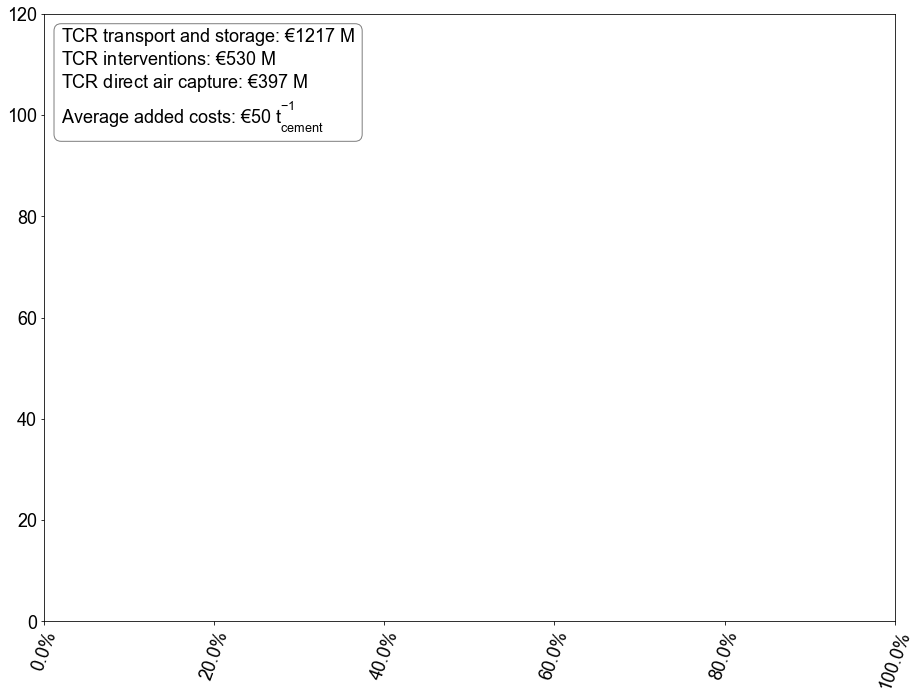

In [64]:

#create figure:
fig, ax = plt.subplots()
scale = 100

figure_width = 6 #cm
figure_height = 4.4 #cm
fig.set_size_inches (figure_width*2.54, figure_height*2.54)

def formatter(x, pos):
    "this function deletes the x or y axis labels and makes percentage out of them"
    del pos
    return f"{str(round(x*100,0))}%"

ax.xaxis.set_major_formatter(formatter)

#add text box to left corner: 

textstr =(f"TCR transport and storage: $€${1217} $M$\n"
    f"TCR interventions: $€${530} $M$\n"
    f"TCR direct air capture: $€${397} $M$\n"
    f"Average added costs: $€${50} $t^{{-1}}_{{cement}}$"
    )

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5, pad = 0.4)

# make all text non-italic:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

# place a text box in upper left in axes coords
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)


ax = plt.gca()
ax.set_ylim([0, 120])
plt.xticks(rotation=70)

plt.savefig("C:/Users/bst3191/OneDrive - Technische Universität Berlin/Promotion/Papers/Geospatial-paper/Figures/Textbox_UK_50.svg",transparent=True)
plt.show()


Export as CSV

In [65]:
df_grid_filtered_cement.to_csv(f"{resultPath_postprocessing}/Results_{country}_{name_run}.csv",sep=';', index=False)

---
## Export chosen inteventions as shapefiles

Add coordinates to results sheets:

In [66]:
def add_geometry_for_IDRC_outputs (df_results, gdf_input):
    gdf_grid_idric_short = gdf_input[['OID','Grid_id','geometry']].copy()
    df_results.rename(columns={'grid':'Grid_id'}, inplace=True)

    #merge two dataFrames and add indicator column
    all_df = pd.merge(df_results, gdf_grid_idric_short, on=['Grid_id'], how='right', indicator='exists')

    #add column to show if each row in first DataFrame exists in second
    all_df['exists'] = np.where(all_df.exists == 'both', True, False)
    all_df_filtered = all_df[all_df['exists']==True].copy()
    all_df_filtered.drop(columns={'exists'}, inplace= True)
    return all_df_filtered

In [67]:
#make geodataframe from input: 
gdf_grid_idric = make_geo_dataframe(df_grid_idric)

#add coordinates to each export dataframes:
gdf_results_tech_invest = add_geometry_for_IDRC_outputs (df_results_idric_tech_invest, gdf_grid_idric)
gdf_results_nets_invest  = add_geometry_for_IDRC_outputs(df_results_idric_nets_invest, gdf_grid_idric)
gdf_results_nets_invest = gdf_results_nets_invest [gdf_results_nets_invest.capacity != 0] #drop when NETs are installed with 0 capacity

Save to shapefile:

In [68]:
def swap_xy(geom):
    #This function changes x and y coordinates, taken from https://gis.stackexchange.com/questions/291247/interchange-y-x-to-x-y-with-geopandas-python-or-qgis
    if geom.is_empty:
        return geom

    if geom.has_z:
        def swap_xy_coords(coords):
            for x, y, z in coords:
                yield (y, x, z)
    else:
        def swap_xy_coords(coords):
            for x, y in coords:
                yield (y, x)

    # Process coordinates from each supported geometry type
    if geom.type in ('Point', 'LineString', 'LinearRing'):
        return type(geom)(list(swap_xy_coords(geom.coords)))
    elif geom.type == 'Polygon':
        ring = geom.exterior
        shell = type(ring)(list(swap_xy_coords(ring.coords)))
        holes = list(geom.interiors)
        for pos, ring in enumerate(holes):
            holes[pos] = type(ring)(list(swap_xy_coords(ring.coords)))
        return type(geom)(shell, holes)
    elif geom.type.startswith('Multi') or geom.type == 'GeometryCollection':
        # Recursive call
        return type(geom)([swap_xy(part) for part in geom.geoms])
    else:
        raise ValueError('Type %r not recognized' % geom.type)

In [69]:
save_tech_invest =False
save_net_invest = False

if save_tech_invest:
# export as shapefile
    #swap xy coordinates: 
    gdf_results_tech_invest['geometry'] =  gdf_results_tech_invest['geometry'].apply(lambda x: swap_xy(x))
    gdf_results_tech_invest = gpd.GeoDataFrame(gdf_results_tech_invest , geometry='geometry' , crs=4326)
    gdf_results_tech_invest.to_file(f"{resultPath_postprocessing}/Interventions_{country}_{name_run}.shp", driver='ESRI Shapefile')

if save_net_invest:
    if not df_results_idric_nets_invest.empty:
# export  as shapefile
        #swap xy coordinates: 
        gdf_results_nets_invest['geometry'] =  gdf_results_nets_invest['geometry'].apply(lambda x: swap_xy(x))
        gdf_results_nets_invest  = gpd.GeoDataFrame(gdf_results_nets_invest , geometry='geometry' , crs=4326)
        gdf_results_nets_invest.to_file(f"{resultPath_postprocessing}/Enduse_{country}_{name_run}.shp", driver='ESRI Shapefile')    

----

## Plot results as Maps

In [70]:
gdf_grid_filtered_cement = make_geo_dataframe(df_grid_filtered_cement)
x = gdf_grid_filtered_cement["LCOP_total_w_nets"]

fig = go.Figure(data=go.Scattergeo(
    lat = gdf_grid_filtered_cement.geometry.x,
    lon = gdf_grid_filtered_cement.geometry.y,
    mode = 'markers',
    text = round(x, 2),
    marker = dict(
        color = x,
        size = 5,
        colorscale='Portland',
        #reversescale = True,
        colorbar_title = 'delta €/tcement',
        cmax = 120,
        cmin = 40,
        cmid = 52.5,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 10)
    ),
))

fig.update_layout(
    geo = dict(
        scope='europe',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        showframe=True,
        framecolor = '#000000',
        projection = dict(
            type = 'natural earth', scale = 2
        ),
    ),
    #title='Total cost per kg H2 (Eur) for H2 required in Cologne, Germany',
    font_color='black',
    font_size=12,
    font_family='Arial'
)
# set size
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    #paper_bgcolor="LightSteelBlue",
)

fig.write_html(f"{resultPath_postprocessing}/cost_map_{country}_{name_run}.html")
fig.show()
#fig.write_image("Results/Graphs/total_cost_map_cologne.pdf", width=600, height=500, scale=1)